# Pets - Revisited

In this notebook, we will use `MultiCategoryBlock` in a specially clever way to have our model return no labels when the given example does not belong to any of the classes seen during training. So let's repurpose our previous code for the dataset `pets` to be able to tell if an image does not belong to any of the breeds seen during training, e.g. a donkey picture. 

### Imports

In [ ]:
!pip install fastai -q --upgrade

     |████████████████████████████████| 194kB 11.9MB/s 


In [ ]:
from fastai.vision.all import *

### Getting our Data

In [ ]:
path = untar_data(URLs.PETS)/'images'

In [ ]:
path.ls()[:3]

(#3) [Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_99.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_36.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_108.jpg')]

We'll go ahead and make the dataloaders with one important change, the get_y function since MutiCategoryBlock expects a list of labels. 

Now we pass that into our `get_y` along with any labeller

In [ ]:
pets_multi = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=Pipeline([RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'), lambda label: [label]]),
                 item_tfms=RandomResizedCrop(460, min_scale=0.75),
                 batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = pets_multi.dataloaders(untar_data(URLs.PETS)/"images",  bs=32)

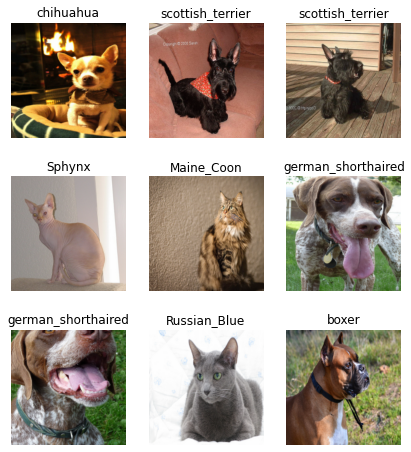

In [ ]:
dls.show_batch(max_n=9, figsize=(7,8))

## Training our Model

Note below a very important detail which is that there are two different thresholds. The metric will use a very high threshold so that only highly confident predictions are accepted as correct. The loss function, however, uses the default 0.5 threshold so that the model is not incentivated to make extreme predictions even if unsure.

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[partial(accuracy_multi, thresh=0.95)], loss_func=BCEWithLogitsLossFlat(thresh=0.5)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fine_tune(epochs=4, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.405870,0.066770,0.973650,01:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.052957,0.023545,0.981312,01:14
1,0.025890,0.014233,0.989120,01:15
2,0.015388,0.010931,0.991790,01:15
3,0.010660,0.010087,0.992448,01:15


In [ ]:
learn.save('cats-vs-dogs')

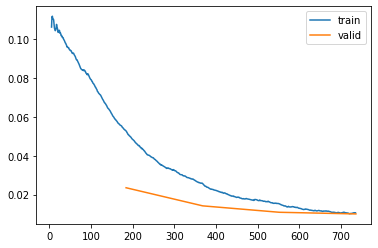

In [ ]:
learn.recorder.plot_loss()

That looks very nice..! Let's see how we did in the next section.

### Model evaluation

In [ ]:
learn.loss_func=BCEWithLogitsLossFlat(thresh=0.95)

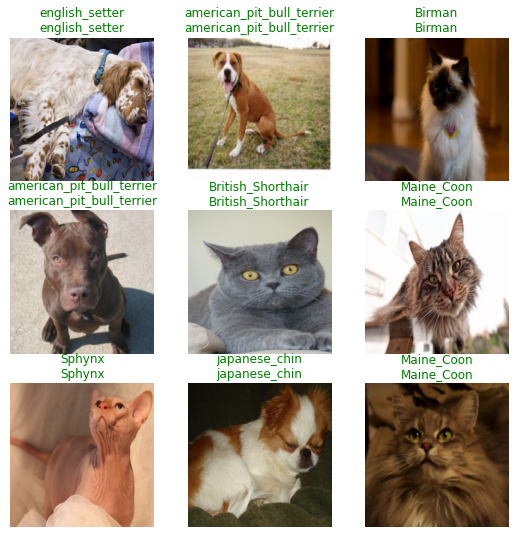

In [ ]:
learn.show_results()

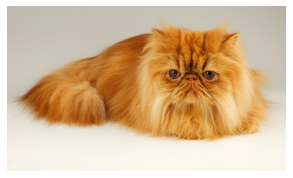

In [ ]:
img = PILImage.create('persian_cat.jpg')
img.show()

In [ ]:
learn.predict(img)[0]

(#1) ['Persian']

Awesome! The model returns only one label and it is the correct one. Let's see if we try with a donkey picture...

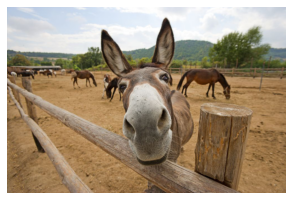

In [ ]:
img = PILImage.create('donkey.jpg')
img.show()

In [ ]:
learn.predict(img)[0]

(#0) []

Nothing! Our classifier is smart enough to return no label if the picture does not belong to any of the classes seen during training. Isn't it great?

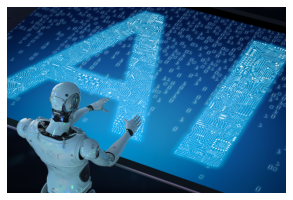

In [ ]:
img = PILImage.create('real-ai.jpg')
img.show()

In [ ]:
learn.predict(img)[0]

(#0) []